In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# read in data and look at target variable
data = pd.read_csv('LoanStats3a.csv')

/var/folders/0w/pvg4kzqx7757341_gst5jz6h0000gp/T/ipykernel_28535/3522930363.py:2: DtypeWarning: Columns (46) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('LoanStats3a.csv')


In [4]:
data.shape

(42538, 144)

In [5]:
TARGET_VAR = 'loan_status'

<Axes: xlabel='loan_status', ylabel='Count'>

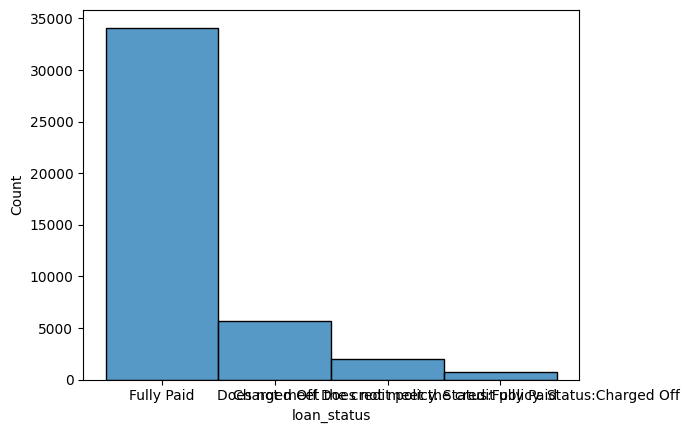

In [6]:
sns.histplot(data[TARGET_VAR])

We are looking to determine whether or not the loan is expected to be paid off, so we can binarize these into "Fully Paid" and everything else. Inspect the data a bit more.

In [ ]:
categorical_features = [x for x in data.dtypes.keys() if data.dtypes[x] == object]
numeric_features = [col for col in data.columns if pd.api.types.is_numeric_dtype(data[col])]
print(f'CATEGORICALS: {len(categorical_features)}')
print(f'NUMERIC: {len(numeric_features)}')

for cat in categorical_features:
    print(cat.upper())
    print(data[cat].describe())

We have some categorical and many numeric features. After inspecting the data, we find that we need to convert some categoricals to either binary or numeric. We will one-hot-encode any categorical features that have only a small number of classes. Lastly, we'll drop any remaining features that have very few classes or are largely NaN. 

In [9]:
DROP = ['member_id'] # drop member id, add more to this list as we go
# take only instances that aren't missing target var
data = data[data[TARGET_VAR].notna()].copy()
# replace NaN with 0
data.fillna(0, inplace=True)

# Convert target vars to 0 and 1
data['loan_status'] = data['loan_status'].apply(lambda x: 1 if x == 'Fully Paid' else 0)

# convert Y/N to 0 and 1
data['debt_settlement_flag'] = data['debt_settlement_flag'].apply(lambda x: 1 if x == 'Y' else 0)

# Convert percentage strings to floats
for var in ['revol_util', 'int_rate']:
    data[var] = data[var].apply(lambda x: float(str(x).replace('%', '')))

# Convert "N months" to int
data['term'] = data['term'].apply(lambda x: int(str(x).replace(' months', '')))

# Convert letter grade to numeric
letter_mapping = {n: i for i, n in enumerate(list('ABCDEFG'))}
data['grade'] = data['grade'].apply(lambda x: letter_mapping[x])

# Engineer some more features that could be helpful
data['diff_installment_last_pymnt'] = data['installment'] - data['last_pymnt_amnt'] # difference between monthly installent amount and amount paid
data['total_repayment_amnt'] = data['installment'] * data['term'] # total amount to be repaid
data['fund_amt_per_month'] = data['funded_amnt'] / data['term'] # amount loaned broken down by month

for f in data.columns:
    if data[f].value_counts().shape[0] == 1:
        DROP.append(f)

# and then a couple others that had very few classes or data was missing for the vast majority of instances
DROP.extend(
    [
        'tax_liens', 
        'delinq_amnt', 
        'settlement_date', 
        'debt_settlement_flag_date', 
        'settlement_status', 
        'verification_status'
    ]
)
# Next payment date seems irrelevant for predicting loan default
DROP.append('next_pymnt_d')

# Drop other categorical variables for now--we'll return to them later
DROP.extend(
    [
        'last_credit_pull_d', 
        'last_pymnt_d', 
        'earliest_cr_line', 
        'issue_d', 
        'desc',
        'home_ownership',
        'purpose',
        'settlement_status',
        'verification_status',
        'addr_state',
        'zip_code',
        'emp_length',
        'emp_title',
        'sub_grade',
        'title'
    ]
)

target = data[TARGET_VAR]
df = data.loc[:,list(set(data.columns) - set(DROP + [TARGET_VAR]))]

df.shape

(42535, 35)

Train the model so we can look at some residuals.

In [33]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.metrics import classification_report

X = df.values
y = target.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43)

clf = LogisticRegression()
clf.fit(X_train, y_train)

/Users/ellynkeith/PycharmProjects/ML_AI/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

Check accuracy on Train and Test sets.

In [30]:
print('TRAIN SET', classification_report(y_train, clf.predict(X_train)))
print('TEST SET', classification_report(y_test, clf.predict(X_test)))

TRAIN SET               precision    recall  f1-score   support

           0       0.97      0.78      0.86      6808
           1       0.95      0.99      0.97     27220

    accuracy                           0.95     34028
   macro avg       0.96      0.89      0.92     34028
weighted avg       0.95      0.95      0.95     34028

TEST SET               precision    recall  f1-score   support

           0       0.98      0.79      0.87      1611
           1       0.95      1.00      0.97      6896

    accuracy                           0.96      8507
   macro avg       0.96      0.89      0.92      8507
weighted avg       0.96      0.96      0.95      8507



Accuracy is excellent. F1 for class 1 also looks good. The priority here is clearly improving recall for class 0. First, check some goodness-of-fit metrics and plot residuals.

In [31]:
from sklearn.metrics import mean_squared_error

y_pred = clf.predict_proba(X_test)[:, 1]
residuals = y_test - y_pred

# Number of observations and number of predictors
n = len(y)
p = X.shape[1]

mse = mean_squared_error(y_test, y_pred)
ssr = np.sum((y_pred - np.mean(y)) ** 2)
rss = np.sum(residuals ** 2)
f_stat = (ssr / p) / (rss / (n - p - 1))

print('Mean Squared Error:', mse, '\nF-statistic:', f_stat)

Mean Squared Error: 0.041732569105548005 
F-statistic: 3355.1773976078503


MSE is low and F-statistic is high, so that's good.

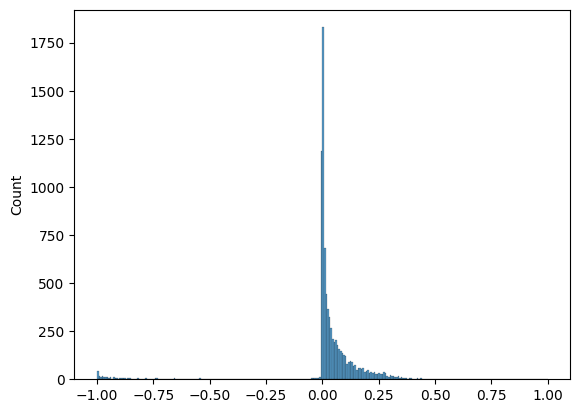

In [12]:
sns.histplot(residuals)
plt.show()

This plot of residuals tells the same story as the classification report: we have a positive bias, wherein we underestimate the probability of the positive class. Perform error analysis on these FNs.

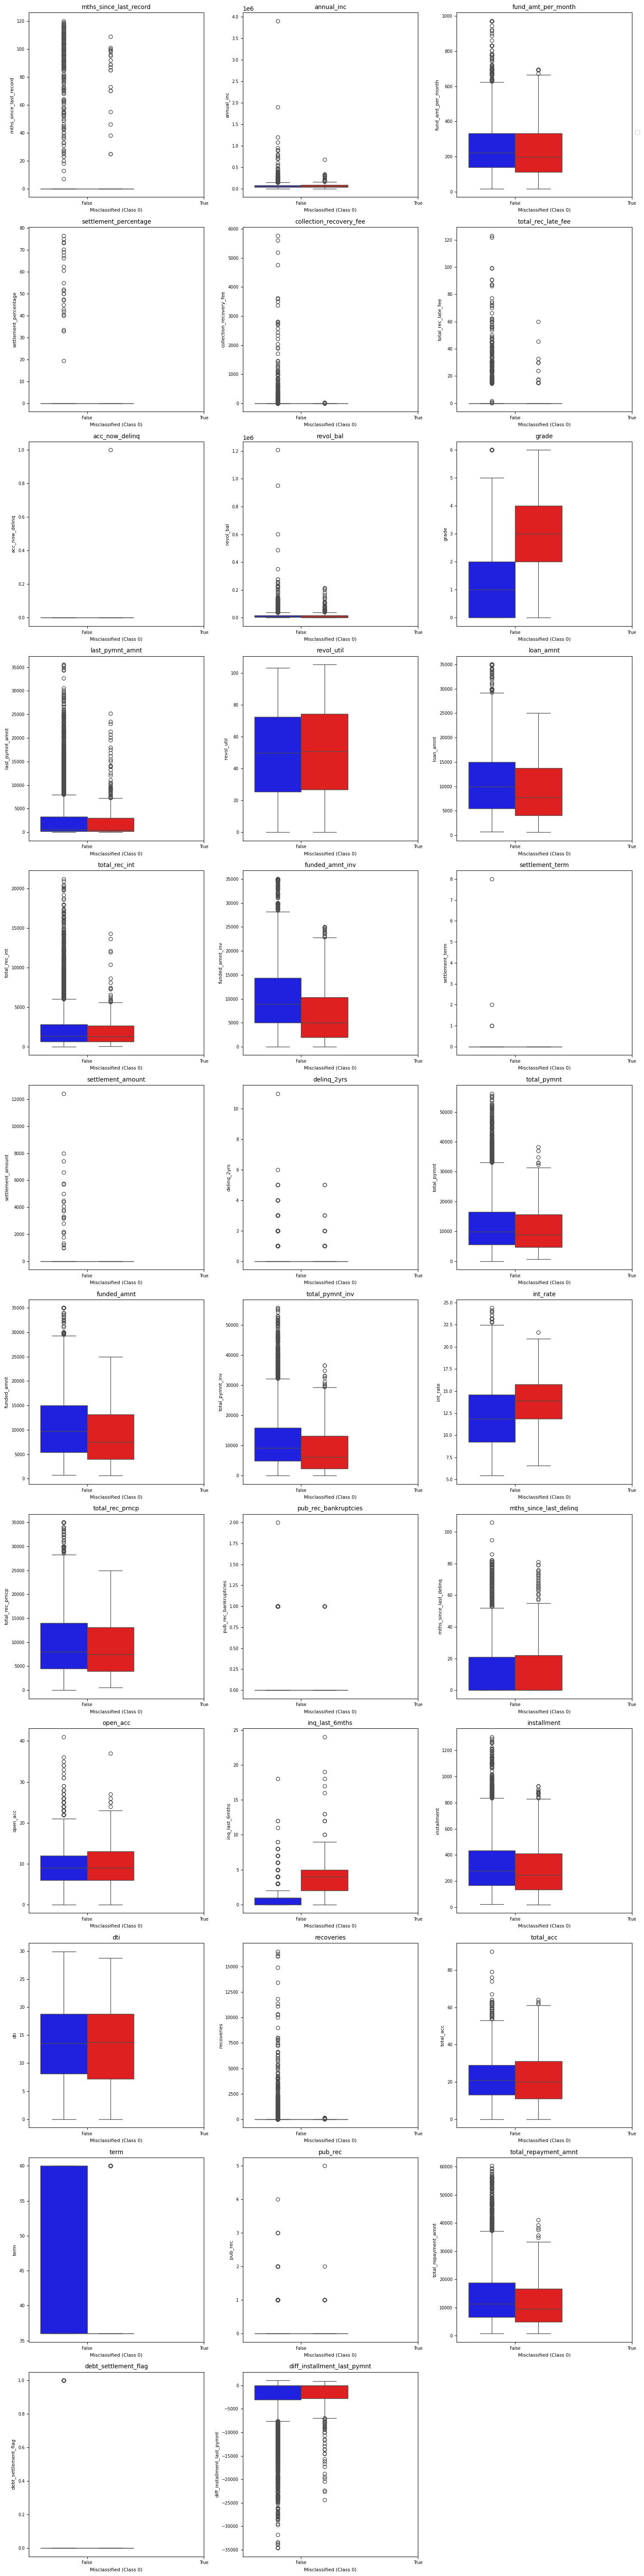

In [45]:
temp_df = pd.DataFrame(X_test, columns=df.columns)
temp_df['y_expected'] = y_test
temp_df['y_pred'] = clf.predict(X_test)
temp_df['is_fn'] = (temp_df['y_expected'] == 0) & (temp_df['y_pred'] == 1)
temp_df['is_fn'] = temp_df['is_fn'].astype(str)

num_features = len(temp_df.columns) - 3
rows = (num_features + 2) // 3
cols = min(num_features, 3)

fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axes = axes.flatten()

for i, feature_name in enumerate(temp_df.columns[:-3]):
    sns.boxplot(y=temp_df.iloc[:, i], x=None, hue=temp_df['is_fn'], data=temp_df, palette={'False': 'blue', 'True': 'red'}, legend=False, ax=axes[i])
    axes[i].set_title(f'{feature_name}', fontsize=10)
    axes[i].set_xlabel('Misclassified (Class 0)', fontsize=8)
    axes[i].set_ylabel(feature_name, fontsize=8)
    axes[i].tick_params(axis='both', which='major', labelsize=7)
    axes[i].set_xticks([0, 1])
    axes[i].set_xticklabels(['False', 'True'], fontsize=7)

# Remove any unused subplots
if num_features < rows * cols:
    for j in range(num_features, rows * cols):
        fig.delaxes(axes[j])

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, ['True Negative', 'False Negative'], loc='upper right', bbox_to_anchor=(1, 0.95))

plt.tight_layout()
plt.show()

In [39]:
_df = df.copy()
_df[TARGET_VAR] = target
_df['color'] = ['FNs' if abs(x) < 0.4 else 'TPs' for x in residuals]

features = [c for c in _df.columns if c not in ['loan_status', 'color']]
charged_off = _df[_df['loan_status'] == 0]

fig, axes = plt.subplots(nrows=len(features), ncols=1, figsize=(10, 5 * len(features)))
palette = {
    'FNs': 'red',
    'TPs': 'blue'
}
for i, feature in enumerate(features):
  ax = axes[i]
  sns.kdeplot(
        data=charged_off,
        x=charged_off[feature],
        hue='color',
        ax=ax,
        palette=palette,
        fill=True
    )
  ax.set_xlabel(feature)
  ax.set_ylabel('Loan Status')
  ax.set_title(f'{feature} vs. loan status')

plt.tight_layout()
plt.show()

ValueError: Length of values (8507) does not match length of index (42535)

Look at correlation coefficients to see if we can be informed by them to reduce noise.

In [36]:
corrs = pd.DataFrame({
    'feature': df.columns,
    'coef': clf.coef_[0]
}).sort_values(by='coef', key=abs, ascending=False)

In [37]:
corrs.head(10)

,feature,coef
21,total_rec_prncp,0.004318
18,funded_amnt,-0.004037
12,total_rec_int,-0.002215
19,total_pymnt_inv,0.001574
13,funded_amnt_inv,-0.001516
28,recoveries,-0.001327
15,settlement_amount,-0.000721
17,total_pymnt,0.000717
26,installment,-0.000714
2,fund_amt_per_month,-0.000577


While the classification metrics were pretty good, all these correlation coefficients are extremely small. This suggests that the relationship between each feature and the target is more complex than simply linear.

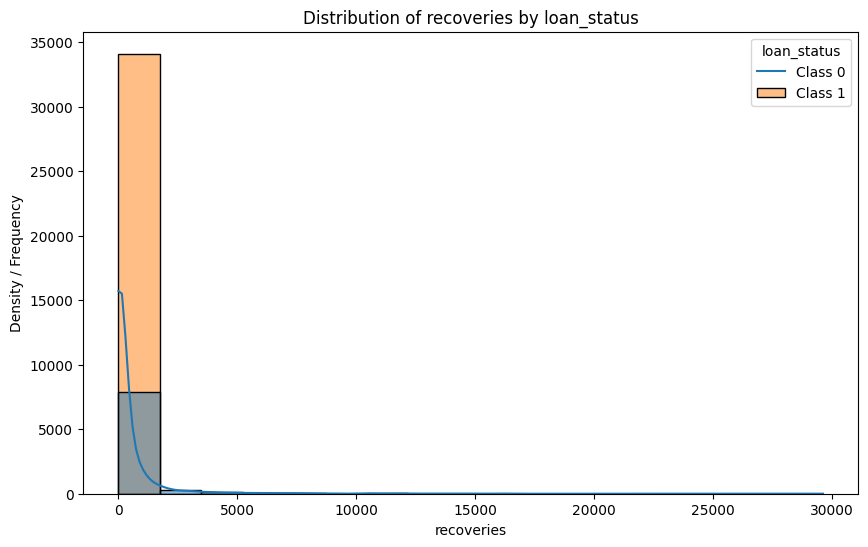

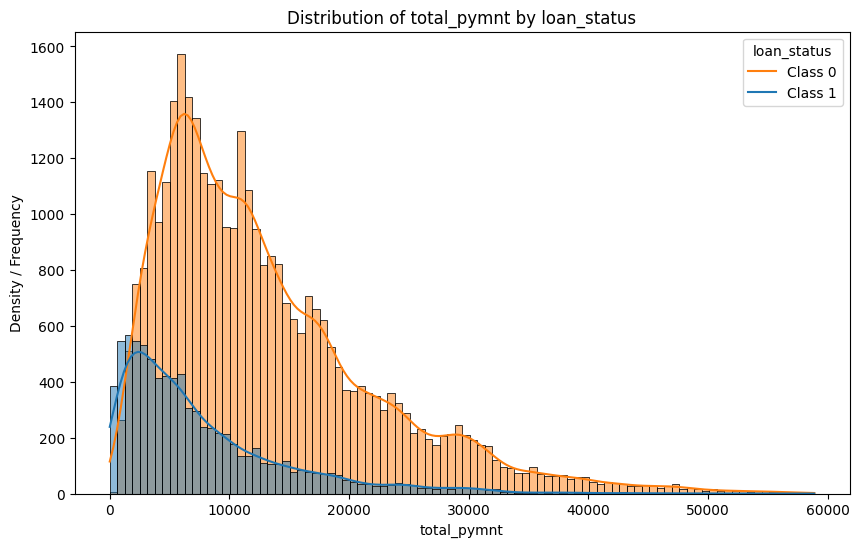

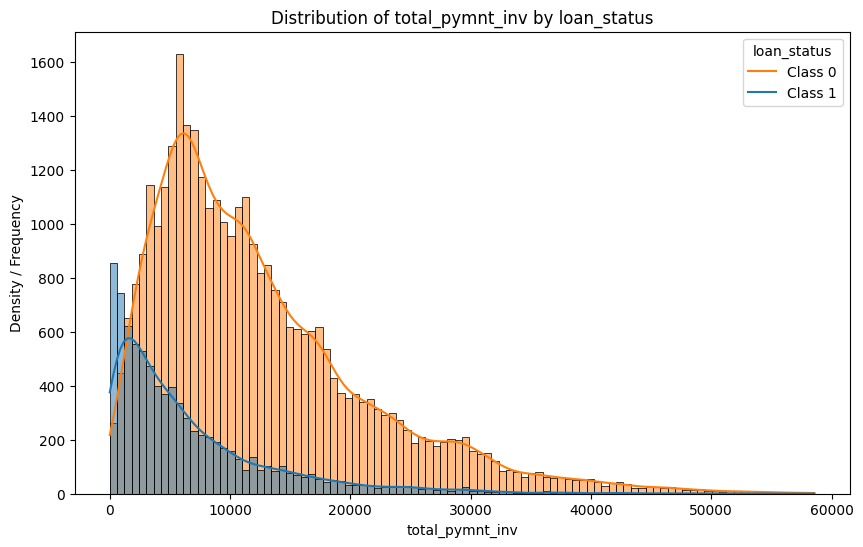

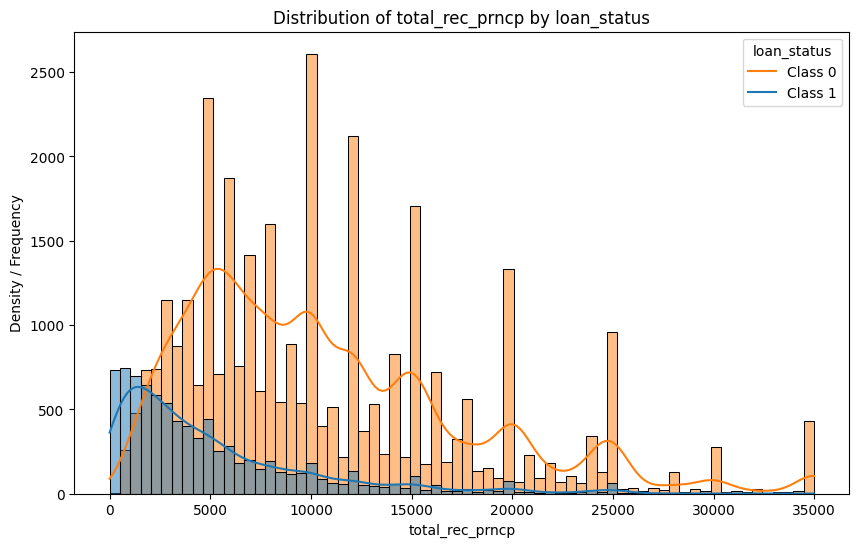

In [24]:
def plot_hist_density_by_target(df, feature_name, target_name):
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x=feature_name, hue=target_name, kde=True)
    plt.title(f'Distribution of {feature_name} by {target_name}')
    plt.xlabel(feature_name)
    plt.ylabel('Density / Frequency')
    plt.legend(title=target_name, labels=['Class 0', 'Class 1'])
    plt.show()

numerical_features = [f for f in df.select_dtypes(include=['number']).columns.tolist() if f in df.columns]

# if 'target' in numerical_features:
#     numerical_features.remove('target')

for feature in ['recoveries', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp']:
    plot_hist_density_by_target(data, feature, TARGET_VAR)

These visualizations suggest that some of these features are just adding noise. Others show a strong distribution difference between the 2 classes. Given that initial accuracy was so high, we will try retraining the model with a small subset of features:
total_pymnt
total_rec_int
total_acc
total_rec_prncp
total_repayment_amnt
revol_util
revol_bal
total_pymnt_inv

In [25]:
features_to_keep = ['total_pymnt', 'total_rec_int', 'total_rec_prncp', 'total_repayment_amnt', 'total_pymnt_inv']
df_subset = data.loc[:,['recoveries', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp']]

In [26]:
df_subset.shape
target.shape

(42535,)

In [32]:
X = df_subset.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43)

clf = LogisticRegression()
clf.fit(X_train, y_train)
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.99      0.76      0.86      1611
           1       0.95      1.00      0.97      6896

    accuracy                           0.95      8507
   macro avg       0.97      0.88      0.92      8507
weighted avg       0.95      0.95      0.95      8507

